 <font size=6> **实验11 多层感知机**</font>

- 1、理解多层感知机的概念、构成和代码实现；
- 2、理解模型选择相关概念、影响因素，掌握深度学习中权重衰减、暂退法等正则化技术；
- 3、理解前向传播、反向传播的概念和梯度计算的思路，了解数值稳定性和模型初始化的重要性。

# MLP应用于Activity

**(实验报告提交题)**  在实验10中提供了Activity_data.csv文件，它包含了4501行、61列的数据资料(数据集)，其中：前60列为特征、最后1列为分类结果标签(15个类，用0-14数字表示)，数据集第一行为列标题。  
- 在实验10的代码基础上修改代码，实现MLP，网络结构包含三层，其中两个隐藏层大小分别为32、32，激活函数使用relu函数，第一个隐藏层中要使用dropout(丢弃概率为0.2)，用训练集数据训练模型(50轮)，再用测试集数据检验模型，输出准确率。

## 导入库

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from d2l import torch as d2l
from d2l_ex import train_ch3
from torch.utils.data import DataLoader, TensorDataset

## 数据处理

In [3]:
data = pd.read_csv('Activity_data.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

C:\Users\Rossana Chan\AppData\Local\Temp\ipykernel_5768\219187979.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\Rossana Chan\AppData\Local\Temp\ipykernel_5768\219187979.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\Rossana Chan\AppData\Local\Temp\ipykernel_5768\219187979.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.int64)
C:\Users\Rossana Chan\AppData\Local

In [5]:
batch_size = 32
train_iter = DataLoader(TensorDataset(X_train, y_train), batch_size, shuffle=True)
test_iter = DataLoader(TensorDataset(X_test, y_test), batch_size, shuffle=False)

## 建模

### 初始化模型

In [6]:
net = nn.Sequential(
    nn.Linear(60, 32), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(32, 16), nn.ReLU(),
    nn.Linear(16, 15)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Linear(in_features=60, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=15, bias=True)
)

### 定义损失函数

In [7]:
loss=nn.CrossEntropyLoss()

### 定义优化算法

In [8]:
lr = 0.01
trainer = torch.optim.SGD(net.parameters(), lr=lr)

### 训练

epoch:50----train loss:0.012325499840080738; train acc:0.8119444444444445; test acc:0.8211111111111111


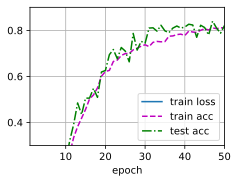

In [9]:
num_epochs = 50

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 测试集评估

In [10]:
d2l.evaluate_accuracy_gpu(net, test_iter)

0.8211111111111111

# MLP应用于人脸分类

**(实验报告提交题)**  实验10从fetch_lfw_people数据集中选择了7位名人的脸部照片，采用softmax回归实现了人脸照片的多分类。

从训练结果可视化图中可以看出，测试集准确率和训练集准确率有较大的差异，存在过拟合现象。
* 要求：对上次实验的模型做修改，加入隐藏层，构造多层感知机（MLP），采用暂退法(drop out)和权重衰减(weight decay)两种方法减轻过拟合，并调参后输出模型训练结果可视化图（参考如下），观察过拟合的程度是否有所减轻，模型仍然有较好的预测能力，输出对测试集的预测效果如下。

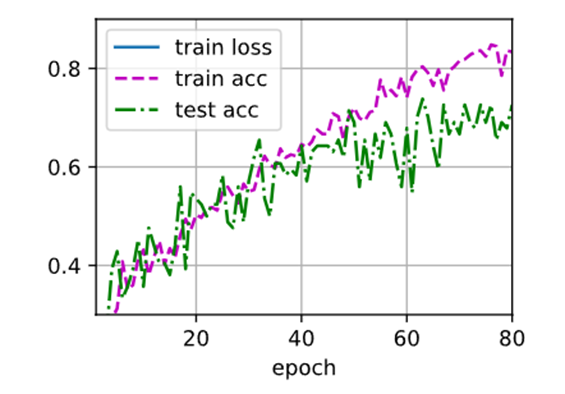
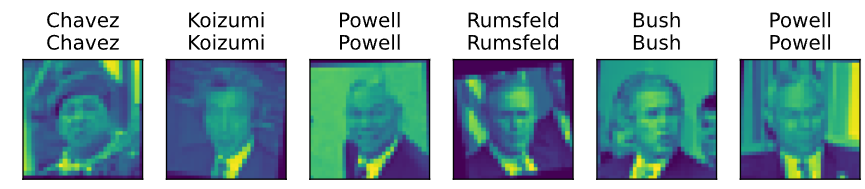

* **提示**：
1.	原始图片像素为250*250，由于训练样本较少，而原图直接训练的参数量较大，建议先将图片先resize做压缩
2.	可能需要调参的超参数包括：batch_size、lr、num_epoch、隐藏层、dropout、weight_decay


## 导入库

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from d2l import torch as d2l
from d2l_ex import train_ch3
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset
from torch.utils import data
from torch import nn

## 数据处理

### 加载数据

In [3]:
train_data = []
train_labels = []
test_data = []
test_labels = []
SIZE = 50

for idx, pic_dir in enumerate(os.listdir('./pictures/')):
    train_path = os.path.join('./pictures', pic_dir, 'train')
    for filename in os.listdir(train_path):
        if filename.endswith('.jpg'):
            img = Image.open(os.path.join(train_path, filename)).convert('L')
            img = img.resize((SIZE, SIZE))  # 调整大小为 50x50
            img = ToTensor()(img)  # 转换为张量
            train_data.append(img)
            train_labels.append(idx)

    test_path = os.path.join('./pictures', pic_dir, 'test')
    for filename in os.listdir(test_path):
        if filename.endswith('.jpg'):
            img = Image.open(os.path.join(test_path, filename)).convert('L')
            img = img.resize((SIZE, SIZE))  # 调整大小为 50x50
            img = ToTensor()(img)  # 转换为张量
            test_data.append(img)
            test_labels.append(idx)

# 创建 TensorDataset，所有图像都为大小 50x50
lfw_train = TensorDataset(torch.stack(train_data), torch.tensor(train_labels))
lfw_test = TensorDataset(torch.stack(test_data), torch.tensor(test_labels))

### 数据查看

In [4]:
lfw_train[0][0].shape

torch.Size([1, 50, 50])

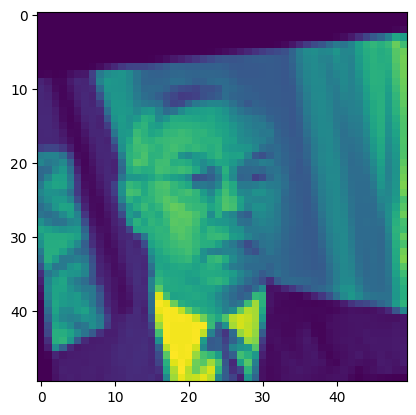

In [5]:
plt.imshow(lfw_train[48][0][0])

### 测试集评估

## 建模

### 初始化模型参数

In [6]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(SIZE * SIZE, 128), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(128, 7)

)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2500, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=128, out_features=7, bias=True)
)

### 定义损失函数

In [7]:
loss = nn.CrossEntropyLoss()

### 定义优化算法

In [8]:
lr = 0.02
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.02)

### 训练

epoch:80----train loss:0.019080516483102525; train acc:0.8392857142857143; test acc:0.6666666666666666


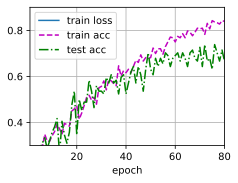

In [9]:
batch_size = 32
num_epochs = 80

train_iter = data.DataLoader(lfw_train, batch_size, shuffle=True)
test_iter = data.DataLoader(lfw_test, batch_size, shuffle=True)

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 预测

### 测试集评估

Junichiro_Koizumi_0001.jpg
Junichiro_Koizumi_0002.jpg
Junichiro_Koizumi_0003.jpg
Junichiro_Koizumi_0004.jpg
Junichiro_Koizumi_0005.jpg
Junichiro_Koizumi_0006.jpg
Junichiro_Koizumi_0007.jpg
Junichiro_Koizumi_0008.jpg
Junichiro_Koizumi_0009.jpg
Junichiro_Koizumi_0010.jpg
Junichiro_Koizumi_0011.jpg
Junichiro_Koizumi_0012.jpg
Junichiro_Koizumi_0013.jpg
Junichiro_Koizumi_0014.jpg
Junichiro_Koizumi_0015.jpg
Junichiro_Koizumi_0016.jpg
Junichiro_Koizumi_0017.jpg
Junichiro_Koizumi_0019.jpg
Junichiro_Koizumi_0021.jpg
Junichiro_Koizumi_0023.jpg
Junichiro_Koizumi_0024.jpg
Junichiro_Koizumi_0025.jpg
Junichiro_Koizumi_0026.jpg
Junichiro_Koizumi_0027.jpg
Junichiro_Koizumi_0029.jpg
Junichiro_Koizumi_0030.jpg
Junichiro_Koizumi_0031.jpg
Junichiro_Koizumi_0033.jpg
Junichiro_Koizumi_0034.jpg
Junichiro_Koizumi_0035.jpg
Junichiro_Koizumi_0036.jpg
Junichiro_Koizumi_0037.jpg
Junichiro_Koizumi_0039.jpg
Junichiro_Koizumi_0041.jpg
Junichiro_Koizumi_0042.jpg
Junichiro_Koizumi_0043.jpg
Junichiro_Koizumi_0044.jpg
J

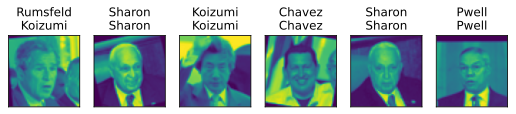

In [10]:
for idx, pic_dir in enumerate(os.listdir('./pictures/')):
    test_path = os.path.join('./pictures', pic_dir, 'test')
    for filename in os.listdir(train_path):
        print(filename)

def get_lfw_labels(labels):
    text_labels = ['Sharon', 'Pwell', 'Bush', 'Rumsfeld', 'Blair', 'Chavez', 'Koizumi']
    return [text_labels[int(i)] for i in labels]

def predict(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_lfw_labels(y)
    preds = get_lfw_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 50, 50)), 1, n, titles=titles[0:n])

predict(net, test_iter)